[*********************100%***********************]  1 of 1 completed


C:\Users\AKSHAT\AppData\Local\Temp/ipykernel_17900/1185968523.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EMA_RVI'] = data['RVI'].ewm(span=13, adjust=False).mean()
C:\Users\AKSHAT\AppData\Local\Temp/ipykernel_17900/1185968523.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crossover'] = np.where(data['RVI'] > data['EMA_RVI'], 1, -1)


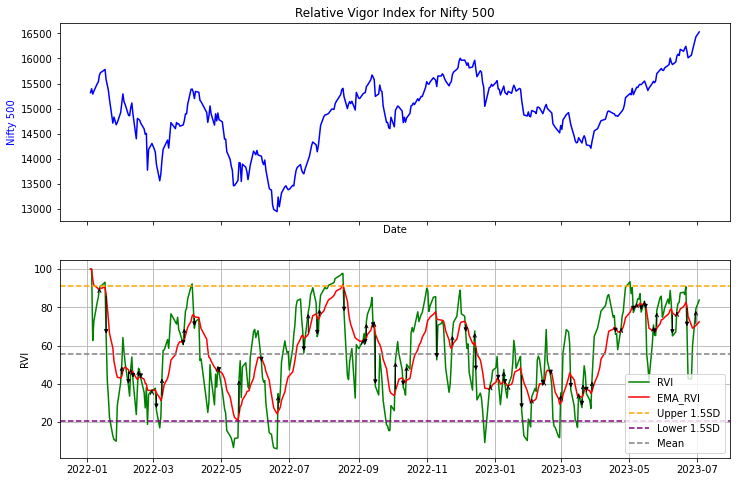

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_rvi(symbol):
    # Fetch historical data from yfinance
    data = yf.download(symbol, start='2022-01-01', end='2023-07-04')

    # Calculate RVI
    data['HLC'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['HLC_prev'] = data['HLC'].shift(1)
    data['CM'] = np.where(data['Close'] > data['Open'], data['Close'] - data['Open'], 0)
    data['VM'] = np.where(data['Close'] <= data['Open'], data['Close'] - data['Open'], 0)
    data['RVGI'] = data['HLC'] - data['HLC_prev']
    data['RVGI_up'] = np.where(data['RVGI'] > 0, data['RVGI'], 0)
    data['RVGI_down'] = np.where(data['RVGI'] < 0, abs(data['RVGI']), 0)
    data['RVGI_EMA_up'] = data['RVGI_up'].ewm(span=10, adjust=False).mean()
    data['RVGI_EMA_down'] = data['RVGI_down'].ewm(span=10, adjust=False).mean()
    data['RVI'] = (data['RVGI_EMA_up'] / (data['RVGI_EMA_up'] + data['RVGI_EMA_down'])) * 100

    # Remove NaN values
    data.dropna(inplace=True)

    return data[['Close', 'RVI']]

# Example usage for Nifty 500
nifty500 = '^CRSLDX'  # Symbol for Nifty 500 index
data = calculate_rvi(nifty500)

# Calculate 13-day EMA of RVI
data['EMA_RVI'] = data['RVI'].ewm(span=13, adjust=False).mean()

# Determine crossovers
data['Crossover'] = np.where(data['RVI'] > data['EMA_RVI'], 1, -1)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Nifty 500
ax1.plot(data.index, data['Close'], color='blue')
ax1.set_ylabel('Nifty 500', color='blue')

# Plot RVI and its 13-day EMA
ax2.plot(data.index, data['RVI'], color='green', label='RVI')
ax2.plot(data.index, data['EMA_RVI'], color='red', label='EMA_RVI')
ax2.set_ylabel('RVI')
ax2.grid(True)

# Mark crossovers with arrows
for i in range(1, len(data)):
    if data['Crossover'].iloc[i] != data['Crossover'].iloc[i - 1]:
        color = 'black' if data['Crossover'].iloc[i] > 0 else 'black'
        arrow_style = '->' if data['Crossover'].iloc[i] > 0 else '-|>'
        ax2.annotate('', xy=(data.index[i], data['RVI'].iloc[i]), xytext=(data.index[i], data['EMA_RVI'].iloc[i]),
                     arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_style), color=color,
                     fontsize=8, ha='center', va='center', xycoords='data', textcoords='data', zorder=10)
mean_rvi = data['RVI'].mean()
std_rvi = data['RVI'].std()

# Calculate upper and lower 2SD lines
upper_sd = mean_rvi + 1.5 * std_rvi
lower_sd = mean_rvi - 1.5 * std_rvi

# Plot upper and lower 2SD lines
ax2.axhline(upper_sd, linestyle='--', color='orange', label='Upper 1.5SD')
ax2.axhline(lower_sd, linestyle='--', color='purple', label='Lower 1.5SD')
ax2.axhline(mean_rvi, linestyle='--', color='gray', label='Mean')

ax1.set_title('Relative Vigor Index for Nifty 500')
ax1.set_xlabel('Date')

plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


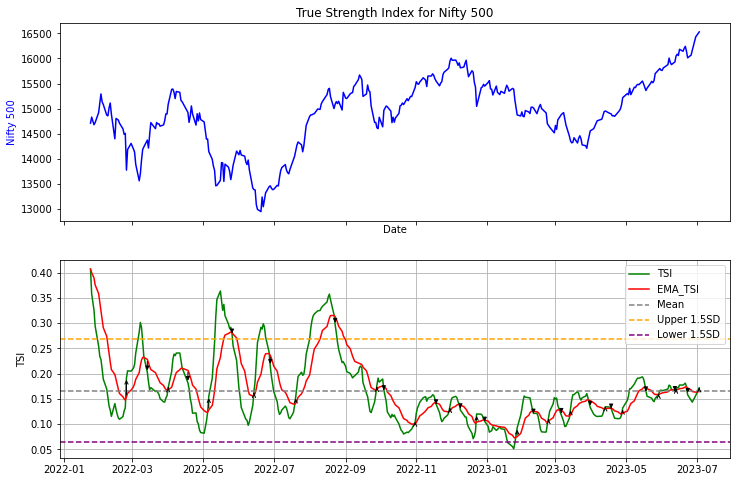

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_tsi(symbol):
    # Fetch historical data from yfinance
    data = yf.download(symbol, start='2022-01-01', end='2023-07-04')

    # Calculate TSI
    data['Close_diff'] = data['Close'].diff()
    data['Close_diff_smoothed'] = data['Close_diff'].ewm(span=25, min_periods=0, adjust=False).mean()
    data['Close_diff_smoothed_abs'] = data['Close_diff_smoothed'].abs()
    data['Close_diff_smoothed_abs_smoothed'] = data['Close_diff_smoothed_abs'].ewm(span=13, min_periods=0, adjust=False).mean()
    data['TSI'] = 100 * data['Close_diff_smoothed_abs_smoothed'] / data['Close'].ewm(span=13, min_periods=0, adjust=False).mean()

    # Remove NaN values
    data.dropna(inplace=True)

    # Remove outliers
    mean_tsi = data['TSI'].mean()
    std_tsi = data['TSI'].std()
    data = data[(data['TSI'] >= mean_tsi - 2 * std_tsi) & (data['TSI'] <= mean_tsi + 2 * std_tsi)]

    return data[['Close', 'TSI']]

# Example usage for Nifty 500
nifty500 = '^CRSLDX'  # Symbol for Nifty 500 index
data = calculate_tsi(nifty500)

# Calculate 13-day EMA of TSI
data['EMA_TSI'] = data['TSI'].ewm(span=13, adjust=False).mean()

# Determine crossovers
data['Crossover'] = np.where(data['TSI'] > data['EMA_TSI'], 1, -1)

# Calculate mean and standard deviation of TSI
mean_tsi = data['TSI'].mean()
std_tsi = data['TSI'].std()

# Calculate upper and lower 1.5SD lines
upper_1_5sd = mean_tsi + 1.5 * std_tsi
lower_1_5sd = mean_tsi - 1.5 * std_tsi

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Nifty 500
ax1.plot(data.index, data['Close'], color='blue')
ax1.set_ylabel('Nifty 500', color='blue')

# Plot TSI and its 13-day EMA
ax2.plot(data.index, data['TSI'], color='green', label='TSI')
ax2.plot(data.index, data['EMA_TSI'], color='red', label='EMA_TSI')
ax2.axhline(mean_tsi, linestyle='--', color='gray', label='Mean')
ax2.axhline(upper_1_5sd, linestyle='--', color='orange', label='Upper 1.5SD')
ax2.axhline(lower_1_5sd, linestyle='--', color='purple', label='Lower 1.5SD')
ax2.set_ylabel('TSI')
ax2.grid(True)

# Mark crossovers with arrows
for i in range(1, len(data)):
    if data['Crossover'].iloc[i] != data['Crossover'].iloc[i - 1]:
        color = 'black' if data['Crossover'].iloc[i] > 0 else 'black'
        arrow_style = '->' if data['Crossover'].iloc[i] > 0 else '-|>'
        ax2.annotate('', xy=(data.index[i], data['TSI'].iloc[i]), xytext=(data.index[i], data['EMA_TSI'].iloc[i]),
                     arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_style), color=color,
                     fontsize=8, ha='center', va='center', xycoords='data', textcoords='data', zorder=10)

ax1.set_title('True Strength Index for Nifty 500')
ax1.set_xlabel('Date')

plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


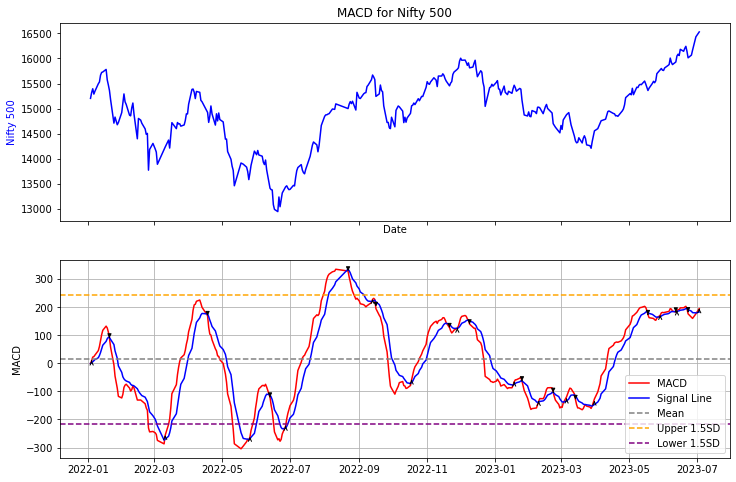

In [14]:
def calculate_macd(symbol):
    # Fetch historical data from yfinance
    data = yf.download(symbol, start='2022-01-01', end='2023-07-04')

    # Calculate MACD
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Remove NaN values
    data.dropna(inplace=True)

    # Remove outliers
    mean_macd = data['MACD'].mean()
    std_macd = data['MACD'].std()
    data = data[(data['MACD'] >= mean_macd - 2 * std_macd) & (data['MACD'] <= mean_macd + 2 * std_macd)]

    return data[['Close', 'MACD', 'Signal_Line']]

# Example usage for Nifty 500
nifty500 = '^CRSLDX'  # Symbol for Nifty 500 index
data = calculate_macd(nifty500)

# Determine MACD crossovers
data['Crossover'] = np.where(data['MACD'] > data['Signal_Line'], 1, -1)

# Calculate mean and standard deviation of MACD
mean_macd = data['MACD'].mean()
std_macd = data['MACD'].std()

# Calculate upper and lower 1.5SD lines
upper_1_5sd = mean_macd + 1.5 * std_macd
lower_1_5sd = mean_macd - 1.5 * std_macd

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Nifty 500
ax1.plot(data.index, data['Close'], color='blue')
ax1.set_ylabel('Nifty 500', color='blue')

# Plot MACD and its signal line
ax2.plot(data.index, data['MACD'], color='red', label='MACD')
ax2.plot(data.index, data['Signal_Line'], color='blue', label='Signal Line')
ax2.axhline(mean_macd, linestyle='--', color='gray', label='Mean')
ax2.axhline(upper_1_5sd, linestyle='--', color='orange', label='Upper 1.5SD')
ax2.axhline(lower_1_5sd, linestyle='--', color='purple', label='Lower 1.5SD')
ax2.set_ylabel('MACD')
ax2.grid(True)

# Mark MACD crossovers with arrows
for i in range(1, len(data)):
    if data['Crossover'].iloc[i] != data['Crossover'].iloc[i - 1]:
        color = 'black' if data['Crossover'].iloc[i] > 0 else 'black'
        arrow_style = '->' if data['Crossover'].iloc[i] > 0 else '-|>'
        ax2.annotate('', xy=(data.index[i], data['MACD'].iloc[i]), xytext=(data.index[i], data['Signal_Line'].iloc[i]),
                     arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_style), color=color,
                     fontsize=8, ha='center', va='center', xycoords='data', textcoords='data', zorder=10)

ax1.set_title('MACD for Nifty 500')
ax1.set_xlabel('Date')

plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


C:\Users\AKSHAT\AppData\Local\Temp/ipykernel_25928/1399006776.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crossover'] = np.where(data['StochRSI_K'] > data['StochRSI_D'], 1, -1)


AttributeError: 'AxesSubplot' object has no attribute 'set_'

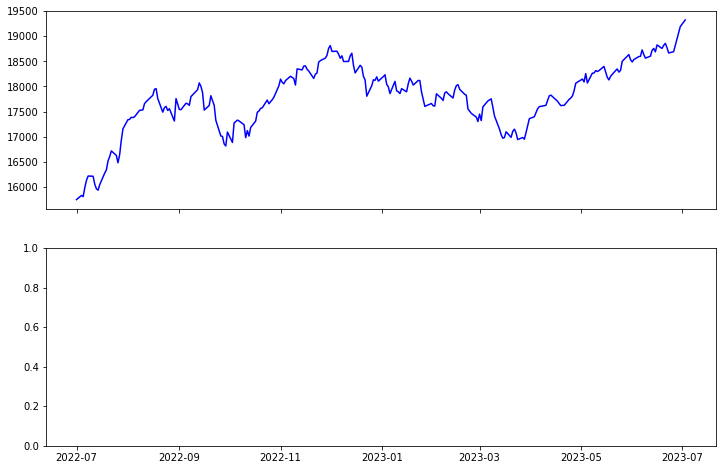

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_stochrsi(symbol, window=14, smooth_k=3, smooth_d=3):
    # Fetch historical data from yfinance
    data = yf.download(symbol, start='2022-07-01', end='2023-07-04')

    # Calculate RSI
    delta = data['Close'].diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Calculate Stochastic RSI
    stochrsi = (rsi - rsi.rolling(window).min()) / (rsi.rolling(window).max() - rsi.rolling(window).min())
    stochrsi_k = stochrsi.rolling(smooth_k).mean()
    stochrsi_d = stochrsi_k.rolling(smooth_d).mean()

    # Remove NaN values
    data.dropna(inplace=True)

    # Add StochRSI, StochRSI_K, and StochRSI_D columns to the DataFrame
    data['StochRSI'] = stochrsi
    data['StochRSI_K'] = stochrsi_k
    data['StochRSI_D'] = stochrsi_d

    return data[['Close', 'StochRSI', 'StochRSI_K', 'StochRSI_D']]

# Example usage for Nifty 500
nifty500 = '^NSEI'  # Symbol for Nifty 500 index
data = calculate_stochrsi(nifty500)

# Determine StochRSI crossovers
data['Crossover'] = np.where(data['StochRSI_K'] > data['StochRSI_D'], 1, -1)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Nifty 500
ax1.plot(data.index, data['Close'], color='blue')
ax1.set_.ylabel('Nifty 500', color='blue')

# Plot StochRSI and its signal line
ax2.plot(data.index, data['StochRSI'], color='red', label='StochRSI')
ax2.plot(data.index, data['StochRSI_K'], color='blue', label='StochRSI_K')
ax2.plot(data.index, data['StochRSI_D'], color='green', label='StochRSI_D')
ax2.set_ylabel('StochRSI')
ax2.grid(True)

# Mark StochRSI crossovers with arrows
for i in range(1, len(data)):
    if data['Crossover'].iloc[i] != data['Crossover'].iloc[i - 1]:
        color = 'green' if data['Crossover'].iloc[i] > 0 else 'red'
        arrow_style = '->' if data['Crossover'].iloc[i] > 0 else '-|>'
        ax2.annotate('', xy=(data.index[i], data['StochRSI'].iloc[i]), xytext=(data.index[i], data['StochRSI_D'].iloc[i]),
                     arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle=arrow_style), color=color,
                     fontsize=8, ha='center', va='center', xycoords='data', textcoords='data', zorder=10)

ax1.set_title('Stochastic RSI for Nifty 500')
ax1.set_xlabel('Date')

plt.legend()
plt.show()
